1. Veriler Yükleniyor ve Saatlik Ortalamalar Alınıyor...
2. Gelişmiş Özellikler (Lag, Rolling, Hafta Sonu) Ekleniyor...
   -> Eğitim Verisi Bitiş Tarihi: 2023-02-27 03:00:00
   -> Test Verisi Başlangıç Tarihi: 2023-02-27 04:00:00
   (Model geleceği görmeden geçmişle eğitiliyor...)
3. Random Forest Modeli Eğitiliyor...
----------------------------------------
✅ BİLİMSEL MODEL SONUÇLARI:
Model Başarısı (R²): %78.47
Ortalama Hata (MAE): 116.97 Watt
----------------------------------------


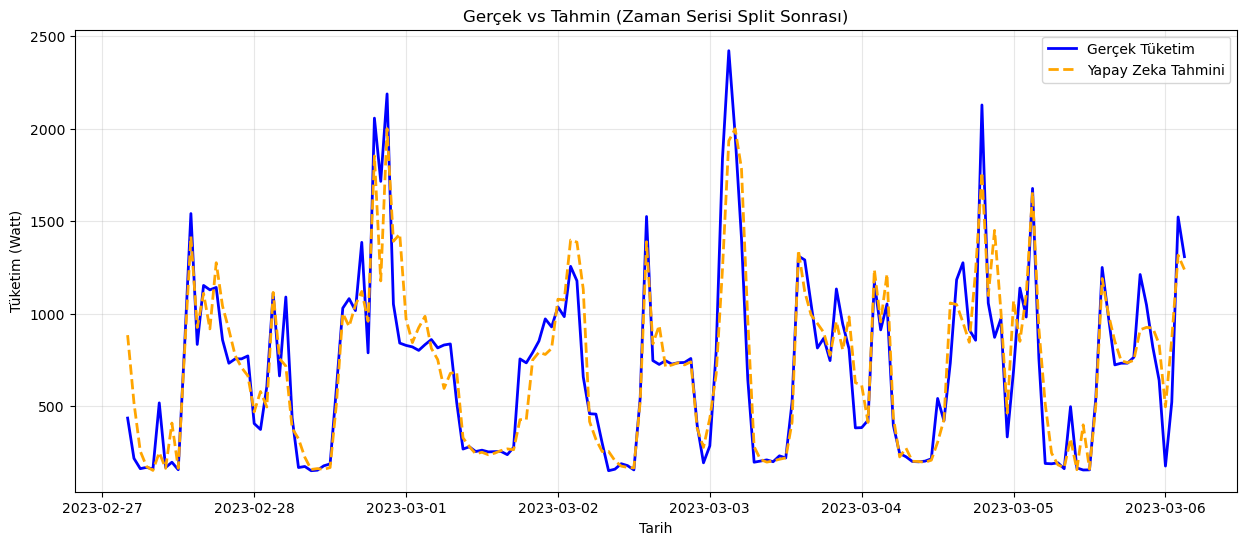


Model İçin En Önemli Veriler:
Hareketli_Ort_3Saat    0.751687
Saat                   0.084836
Tuketim_1Saat_Once     0.069383
Tuketim_24Saat_Once    0.035965
Sicaklik_C             0.030906
Ay                     0.012981
Haftanin_Gunu          0.012853
Hafta_Sonu             0.001389
dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. VERİLERİ YÜKLEME VE STANDARTLAŞTIRMA (GPT Önerisi: Resample)
# ---------------------------------------------------------
print("1. Veriler Yükleniyor ve Saatlik Ortalamalar Alınıyor...")
df_solar = pd.read_csv('temiz_solar_veri.csv', index_col='time', parse_dates=True)
df_tuketim = pd.read_csv('temiz_tuketim_veri_5000kWh.csv', index_col='dt', parse_dates=True)

# Saat dilimlerini temizle
try:
    df_solar.index = df_solar.index.tz_localize(None)
    df_tuketim.index = df_tuketim.index.tz_localize(None)
except TypeError:
    pass 

# GPT ÖNERİSİ 1: .round() yerine .resample('h').mean() kullanımı
# Bu sayede veri kayması olmaz, tam saatlik ortalamalar alınır.
df_solar = df_solar.resample('h').mean()
df_tuketim = df_tuketim.resample('h').mean()

# Birleştirme (Sıcaklık verisini Tüketim'in yanına ekle)
df_merged = pd.concat([df_tuketim, df_solar[['Sicaklik_C']]], axis=1, join='inner')

# 2. ÖZNİTELİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
# ---------------------------------------------------------
print("2. Gelişmiş Özellikler (Lag, Rolling, Hafta Sonu) Ekleniyor...")

# A. Zaman Özellikleri
df_merged['Saat'] = df_merged.index.hour
df_merged['Ay'] = df_merged.index.month
df_merged['Haftanin_Gunu'] = df_merged.index.dayofweek

# GPT ÖNERİSİ 6: Hafta Sonu Bilgisi (0: Hafta içi, 1: Hafta sonu)
# İnsanlar hafta sonu evde daha çok vakit geçirir, tüketim değişir.
df_merged['Hafta_Sonu'] = (df_merged.index.dayofweek >= 5).astype(int)

# B. Hafıza (Lag Features)
# 1 Saat Önceki Tüketim
df_merged['Tuketim_1Saat_Once'] = df_merged['Tuketim_W'].shift(1)
# 24 Saat Önceki (Dün bu saat) Tüketim
df_merged['Tuketim_24Saat_Once'] = df_merged['Tuketim_W'].shift(24)

# GPT ÖNERİSİ 6: Hareketli Ortalama (Rolling Mean)
# Son 3 saatin ortalaması (Trendi yakalamak için)
df_merged['Hareketli_Ort_3Saat'] = df_merged['Tuketim_W'].rolling(window=3).mean()

# İlk oluşan boş satırları (NaN) temizle
df_merged.dropna(inplace=True)

# 3. EĞİTİM VE TEST AYRIMI (GPT ÖNERİSİ 3: Zaman Serisine Uygun Bölme)
# ---------------------------------------------------------
# Rastgele karıştırmak YOK! (Shuffle=False)
# Veriyi ortadan ikiye böler gibi kesiyoruz.
# İlk %80 Eğitim (Geçmiş), Son %20 Test (Gelecek)

split_point = int(len(df_merged) * 0.80)

train_data = df_merged.iloc[:split_point]
test_data = df_merged.iloc[split_point:]

# Girdiler (X) ve Hedef (y)
features = ['Saat', 'Ay', 'Haftanin_Gunu', 'Hafta_Sonu', 'Sicaklik_C', 
            'Tuketim_1Saat_Once', 'Tuketim_24Saat_Once', 'Hareketli_Ort_3Saat']
target = 'Tuketim_W'

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

print(f"   -> Eğitim Verisi Bitiş Tarihi: {train_data.index.max()}")
print(f"   -> Test Verisi Başlangıç Tarihi: {test_data.index.min()}")
print("   (Model geleceği görmeden geçmişle eğitiliyor...)")

# 4. MODEL EĞİTİMİ
# ---------------------------------------------------------
print("3. Random Forest Modeli Eğitiliyor...")
model_tuketim = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_tuketim.fit(X_train, y_train)

# 5. TEST VE DEĞERLENDİRME
# ---------------------------------------------------------
tahminler = model_tuketim.predict(X_test)

r2 = r2_score(y_test, tahminler)
mae = mean_absolute_error(y_test, tahminler)

print("-" * 40)
print(f"✅ BİLİMSEL MODEL SONUÇLARI:")
print(f"Model Başarısı (R²): %{r2*100:.2f}")
print(f"Ortalama Hata (MAE): {mae:.2f} Watt")
print("-" * 40)

# 6. GELİŞMİŞ GRAFİK (GPT ÖNERİSİ 5: Tarih İndeksli Çizim)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))
# Test setinin ilk 1 haftasını (7 gün * 24 saat = 168 saat) çizelim
plot_range = 168 

plt.plot(y_test.index[:plot_range], y_test.values[:plot_range], label='Gerçek Tüketim', color='blue', linewidth=2)
plt.plot(y_test.index[:plot_range], tahminler[:plot_range], label='Yapay Zeka Tahmini', color='orange', linestyle='--', linewidth=2)

plt.title('Gerçek vs Tahmin (Zaman Serisi Split Sonrası)')
plt.xlabel('Tarih')
plt.ylabel('Tüketim (Watt)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Özelliklerin Önem Derecesini Görelim (Hangi veri daha önemliymiş?)
feature_importance = pd.Series(model_tuketim.feature_importances_, index=features).sort_values(ascending=False)
print("\nModel İçin En Önemli Veriler:")
print(feature_importance)